# Notebook with CVAE model and conditionning over calendar features or temperature with bike sharing kaggle dataset

## Loading libraries

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images

In [2]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/CVAE/marota_cvae'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [3]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE
%load_ext autoreload
%autoreload

Using TensorFlow backend.


In [4]:
#directories to store trained model and the related projector

log_dir_projector=path_main_folder+"/notebooks/logs/Expe-bike/CVAE_Wd_casual/projector"
log_dir_model=path_main_folder+"/notebooks/logs/Expe-bike/CVAE_Wd_casual//model"
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)

# Table of contents:
- Load Data
- Make Training Set
- Define and Train Model
- Build Projector
- Compute Feature Scores in latent space
- Study reconstruction Error
- Study Holidays prediction
- Detect atypical events
- Conclusion

## Load dataset

In [5]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data/bike-sharing')
dataset_train= os.path.join(path_data, "bike.csv")

train = pd.read_csv(dataset_train)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
train.datetime = pd.to_datetime(train.datetime)

In [7]:
dates, freq = np.unique(train.datetime.dt.date, return_counts=True)
stats.describe(freq)

DescribeResult(nobs=731, minmax=(1, 24), mean=23.774281805745552, variance=1.824323969791804, skewness=-11.501712989731729, kurtosis=155.61852429648792)

There is a day with only 12 hours of data. This day shall be removed.

In [8]:
target = dates[np.where(freq<22)[0]]
idx = np.array([0])
for tgt in target:
    idx=np.r_[idx,np.where(train.datetime.dt.date==tgt)[0]]
ind = idx[1:]
train = train.drop(index=ind)

## Make training set of daily renting shares profiles and conditions

We use some conditions from expert knowledge we previosuly recovered (temperature, month, days of the week) to learn a new residual latent space.

In [9]:
timeserie = train.datetime.dt
nPoints = len(np.unique(timeserie.date))
nPoints

723

In [10]:
columns=train.columns
columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [11]:
x_conso = train[['datetime', 'casual', 'temp', 'humidity', 'windspeed', 'holiday']].copy()
x_conso[['casual', 'temp', 'humidity', 'windspeed', 'holiday']] = x_conso[['casual', 'temp', 'humidity', 'windspeed', 'holiday']].astype('float64').values
x_conso = x_conso.rename(columns={'datetime':'ds', 'casual':'consumption', 'temp':'temperature', 'holiday':'is_holiday_day'})
x_conso.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17278 entries, 0 to 17378
Data columns (total 6 columns):
ds                17278 non-null datetime64[ns]
consumption       17278 non-null float64
temperature       17278 non-null float64
humidity          17278 non-null float64
windspeed         17278 non-null float64
is_holiday_day    17278 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 944.9 KB


In [12]:
x_conso.describe()

,consumption,temperature,humidity,windspeed,is_holiday_day
count,17278.000000,17278.000000,17278.000000,17278.000000,17278.000000
mean,35.777000,0.497628,0.626563,0.189731,0.028939
std,49.338033,0.192133,0.192887,0.122120,0.167639
min,0.000000,0.020000,0.000000,0.000000,0.000000
25%,4.000000,0.340000,0.480000,0.104500,0.000000
50%,17.000000,0.500000,0.630000,0.194000,0.000000
75%,49.000000,0.660000,0.780000,0.253700,0.000000
max,367.000000,1.000000,1.000000,0.850700,1.000000


In [13]:
dict_xconso = {'train': x_conso}
name_set_plot = 'train'
version = '-v1'
# Normalize input variables
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard', meteo_elements=['temperature', 'humidity', 'windspeed'])
dict_xconso['train'].describe()

['consumption']


,consumption,temperature,humidity,windspeed,is_holiday_day
count,1.727800e+04,1.727800e+04,1.727800e+04,1.727800e+04,17278.000000
mean,-1.315972e-17,-1.842361e-16,-1.480469e-16,7.402344e-18,0.028939
std,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,0.167639
min,-7.251614e-01,-2.486002e+00,-3.248436e+00,-1.553683e+00,0.000000
25%,-6.440857e-01,-8.204374e-01,-7.598616e-01,-6.979448e-01,0.000000
50%,-3.805896e-01,1.234497e-02,1.781788e-02,3.495995e-02,0.000000
75%,2.680160e-01,8.451274e-01,7.954973e-01,5.238361e-01,0.000000
max,6.713535e+00,2.614790e+00,1.936094e+00,5.412597e+00,1.000000


In [14]:
type_x = ['conso']
list_cond = ['day']
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, list_cond=list_cond)

day (723, 7)
(723, 7)


In [15]:
np.unique(np.max(dataset['train']['x'][1], axis=1), )

array([1], dtype=uint8)

In [16]:
sum(np.isnan(dataset['train']['y']))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [17]:
nPoints=dataset['train']['x'][1].shape[0]

#get conditions in array
temp_emb =dataset['train']['x'][1]
#hol_emb = dataset['train']['x'][1][:,7:]

to_emb=dataset['train']['x'][1]

x = dataset['train']['x'][0]

dataset['train']['x'] = [x,temp_emb]

In [18]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0

In [19]:
calendar_info.head(20)

,ds,month,weekday,is_weekday,is_holiday_day
0,2011-01-01,1,5,0,0.0
1,2011-01-02,1,6,0,0.0
2,2011-01-03,1,0,1,0.0
3,2011-01-04,1,1,1,0.0
4,2011-01-05,1,2,1,0.0
5,2011-01-06,1,3,1,0.0
6,2011-01-07,1,4,1,0.0
7,2011-01-08,1,5,0,0.0
8,2011-01-09,1,6,0,0.0
9,2011-01-10,1,0,1,0.0


In [20]:
dates = calendar_info['ds'].dt.date
weather = [train.weather.iloc[np.where(train['datetime'].dt.date==date)[0]].max() for date in dates]
calendar_info=calendar_info.join(pd.get_dummies(weather).rename(columns={1:'clear', 2:'mist', 3:'significant', 4:'extreme'}))
calendar_info.head()

,ds,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme
0,2011-01-01,1,5,0,0.0,0,0,1,0
1,2011-01-02,1,6,0,0.0,0,0,1,0
2,2011-01-03,1,0,1,0.0,1,0,0,0
3,2011-01-04,1,1,1,0.0,0,1,0,0
4,2011-01-05,1,2,1,0.0,1,0,0,0


In [21]:
calendar_info.describe()

,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme
count,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000
mean,6.535270,3.009682,0.712310,0.029046,0.207469,0.384509,0.405256,0.002766
std,3.442816,2.003782,0.452999,0.168051,0.405775,0.486816,0.491281,0.052559
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,5.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,12.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Build and train model CVAE

In [22]:
#on sauvegarde le dataset
path_out = log_dir_model

In [23]:
# Parameters for autoencoder
e_dims=[24,18,12,6]#encoder dim
d_dims=[24,18,12,6]#decoder dim. Dense Blocks in skip connections can make the dimensions bigger when layers are concatenated with the previous one
to_emb_dim=[7] #input dimensions for conditions
cond_pre_dim = 0
input_dim = dataset['train']['x'][0].shape[1]
z_dim= 3


In [24]:
name_model = 'cvae_sharings-T_1H-journalier'
#name_model = 'cvae_classification'

In [25]:
#if needs to relaod model classes after modification wothout restarting the kernel

import CVAE.cvae_model
import CVAE.callbacks
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.callbacks)

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
batch_size = 32
lambda_val = 5 * batch_size/nPoints #hyper-parameter which value was selected after cross-validation
Lambda = K.variable(lambda_val, dtype='float32')
model = CVAE.cvae_model.CVAE_emb(input_dim=input_dim,
                  e_dims=e_dims, 
                  d_dims=d_dims, 
                  cond_pre_dim=cond_pre_dim,
                  z_dim=z_dim, 
                  beta=Lambda,
                  name=name_model, 
                  output=path_out,
                 to_emb_dim=to_emb_dim,
                 emb_dims=[[5,3]], emb_to_z_dim=[3],
                is_L2_Loss=False,has_BN=2, lr=3e-4)#these dimensions define the dimension layer of the conitional network

Instructions for updating:
Colocations handled automatically by placer.
3
L1 loss
False
L1 loss
False
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 7)            0                                            
__________________________________________________________________________________________________
x_true (InputLayer)             (None, 24)           0                                            
__________________________________________________________________________________________________
embedding_enc (Model)           (None, 3)            94          emb_input_0[0][0]                
__________________________________________________________________________________________________
encoder (Model)                 [(None, 3), (None, 3 1578        x_true[0][


## Training model

In [27]:
from keras.callbacks import TensorBoard
from time import time

#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)




--- START TRAINING ---

Instructions for updating:
Use tf.cast instead.
emb_input_0
[17.772734 26.020763 53.91711 ]
0.4041101449275363
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.744974  0.650159  0.102272        0.038095    -6.726296
random model    0.503387  0.166748  0.087232        0.028571    -6.006677
0 Epochs ...  - loss: 20.0857 - decoder_loss: 20.0829 - decoder_for_kl_loss: 0.0126 - decoder_kl_loss: 0.0126 - decoder_recon_loss: 20.0829 - decoder_for_kl_kl_loss: 0.0126 - decoder_for_kl_recon_loss: 20.0829 - val_loss: 17.9966 - val_decoder_loss: 17.9942 - val_decoder_for_kl_loss: 0.0110 - val_decoder_kl_loss: 0.0110 - val_decoder_recon_loss: 17.9942 - val_decoder_for_kl_kl_loss: 0.0110 - val_decoder_for_kl_recon_loss: 17.9942 val_loss 17.996617761376786 ... lambda Loss 0.2213001400232315
emb_input_0
[207.75038 476.1697  700.436  ]
0.23233333333333328
              is_weekday   weekday     month  is_holiday_day  temperature
score 

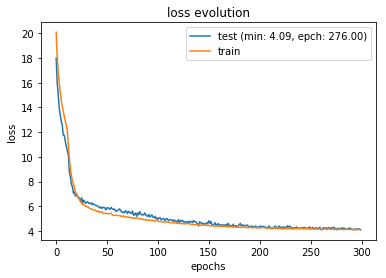

In [28]:
import warnings
warnings.filterwarnings('ignore')

lambda_decreaseRate=0.0
lambda_min=0.01 #p

#Turn it to True to train the model. Otherwise you can directly load on already trained model below
runTraining=True
runBatchCallback=True #In this callback we compute feature scores which is a bit long

if runTraining:#Training a neural network requires some computing power and the CPUs in MyBinder environment can be a bit slow. If you don't use callbacks it can be faster also 
    
    if runBatchCallback:
        out_batch = NEpochLogger(x_train_data=dataset['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
        model.main_train(dataset, training_epochs=300, batch_size=batch_size, verbose=0,callbacks=[tensorboard,out_batch],validation_split=0.1)
    else:
        #use verbose=1 to see logs of training at every epoch
        model.main_train(dataset, training_epochs=300, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.1)




--- START TRAINING ---

emb_input_0
[180.65779 402.36453 615.5697 ]
0.20391666666666672
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.785403  0.280551  0.225677        0.161905    -0.592406
random model    0.433770  0.153585  0.074310        0.047619    -6.294911
0 Epochs ...  - loss: 4.1336 - decoder_loss: 3.3697 - decoder_for_kl_loss: 3.4515 - decoder_kl_loss: 3.4515 - decoder_recon_loss: 3.3697 - decoder_for_kl_kl_loss: 3.4515 - decoder_for_kl_recon_loss: 3.3697 - val_loss: 4.1512 - val_decoder_loss: 3.4402 - val_decoder_for_kl_loss: 3.2128 - val_decoder_kl_loss: 3.2128 - val_decoder_recon_loss: 3.4402 - val_decoder_for_kl_kl_loss: 3.2128 - val_decoder_for_kl_recon_loss: 3.4402 val_loss 4.151237086073993 ... lambda Loss 0.2213001400232315
emb_input_0
[121.53284 409.49533 621.5238 ]
0.20156666666666648
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.771788  0.268292  0.234557        0.180952  

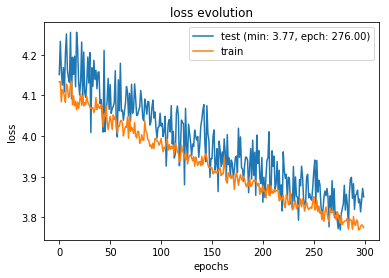

In [29]:
lambda_decreaseRate=0.001 #parameter by default

if runTraining:
    weightLoss=callbackWeightLoss(lambda_val,lambda_decreaseRate,lambda_min)
    if runBatchCallback:
        model.main_train(dataset, training_epochs=300, batch_size=batch_size, verbose=0,callbacks=[tensorboard,out_batch,weightLoss],validation_split=0.1)
    else:
        model.main_train(dataset, training_epochs=300, batch_size=batch_size, verbose=0,callbacks=[tensorboard,weightLoss],validation_split=0.1)


In [30]:
if runTraining:
    with open(os.path.join(log_dir_model,name_model,"config.txt"),'w') as file: 
        file.write(str(cond_pre_dim) + '\n')
        #file.write(str(emb_dims) + '\n')
        file.write(str(e_dims) + '\n') 
        file.write(str(d_dims) + '\n') 
        file.write(str(z_dim) + '\n')
        file.write(str(Lambda) + '\n')

In [31]:
#sauvegarde du dataset associé
if runTraining:
    name_dataset = 'dataset.pickle'

    with open( os.path.join(log_dir_model,name_model, name_dataset), "wb" ) as file:
        pickle.dump( dataset, file )

# Loading model

In [32]:
model.load_model(os.path.join(path_out, name_model, 'models'))

In [33]:
emb_inputs=[temp_emb]
emb_ouputs = model.embedding_enc.predict(emb_inputs)

#cond_pre=day_emb
#cond = np.concatenate((cond_pre, emb_ouputs), axis=1)
cond  = emb_ouputs
x_input = dataset['train']['x'][0]

input_encoder = [x_input,cond]

In [34]:
x_encoded = model.encoder.predict(input_encoder)[0]
x_hat = model.cvae.predict(x=dataset['train']['x'])[0]

# Analysis of the latent space with the construction of a tensorboard projector

In [35]:
includeConsumptionProfileImages=True #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
if includeConsumptionProfileImages:
    nPoints=min(1500,nPoints) #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
    x_encoded_reduced=x_encoded[0:nPoints,]
    images=createLoadProfileImages(x,x_hat,nPoints)
else:
    nPoints=nPoints

<Figure size 432x288 with 0 Axes>

In [36]:
if includeConsumptionProfileImages:
    sprites=images_to_sprite(images)
    cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)

In [37]:
writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
if includeConsumptionProfileImages:
    buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
else:
    buildProjector(x_encoded,images=None, log_dir=log_dir_projector)

In [38]:
log_dir_projector

'/home/goubetcle/Documents/CVAE/marota_cvae/notebooks/logs/Expe-bike/CVAE_Wd_casual/projector'

# Predict Features in latent space

In [49]:
df_noCond_VAE=predictFeaturesInLatentSPace(x_conso,calendar_info,x_encoded)

0.2137311594202897
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.664375  0.213482  0.240825        0.142857    -0.851435
random model    0.486412  0.144978  0.098335        0.038095    -6.499814


Importance of holidays predicted as weekends

## reconstruction error analysis

In [78]:
error=np.sum(np.abs((x - x_hat)),axis=1)/24

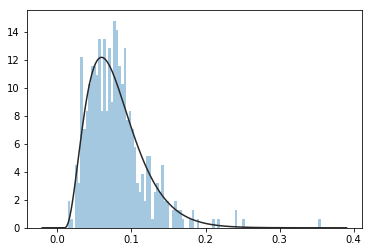

In [81]:
#make a histogram over residuals
import seaborn as sn
sn.distplot(error, kde=False, fit=stats.gamma, bins=100)

In [83]:
ErrorThreshold=0.1
idxMaxError=[i for i in range(0,nPoints) if error[i]>=ErrorThreshold]
calender_error=calendar_info.loc[idxMaxError]
calender_error['error']=error[idxMaxError]
print(len(calender_error))
calender_error

100


,ds,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme,error
2,2011-01-03,1,0,1,0.0,1,0,0,0,0.134544
10,2011-01-11,1,1,1,0.0,0,0,1,0,0.133750
28,2011-02-11,2,4,1,0.0,1,0,0,0,0.132577
76,2011-05-02,5,0,1,0.0,0,1,0,0,0.141567
91,2011-05-17,5,1,1,0.0,0,0,1,0,0.100987
109,2011-06-16,6,3,1,0.0,0,0,1,0,0.116599
111,2011-06-18,6,5,0,0.0,0,1,0,0,0.145186
115,2011-07-03,7,6,0,0.0,0,0,1,0,0.104063
134,2011-08-03,8,2,1,0.0,0,0,1,0,0.143620
144,2011-08-13,8,5,0,0.0,0,0,1,0,0.121587


In [84]:
nDays=15

decreasingOrderIdx=np.argsort(-error)
calendar_Error_Highest=calendar_info.loc[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest['error']=error[decreasingOrderIdx[0:nDays]]
calendar_Error_Highest

,ds,month,weekday,is_weekday,is_holiday_day,clear,mist,significant,extreme,error
423,2012-11-07,11,2,1,0.0,0,0,1,0,0.355801
412,2012-10-15,10,0,1,0.0,0,0,1,0,0.250727
369,2012-08-10,8,4,1,0.0,0,0,1,0,0.242900
317,2012-05-15,5,1,1,0.0,0,0,1,0,0.242221
428,2012-11-12,11,0,1,1.0,0,0,1,0,0.217137
432,2012-11-16,11,4,1,0.0,0,1,0,0,0.210594
380,2012-09-02,9,6,0,0.0,0,0,1,0,0.189104
373,2012-08-14,8,1,1,0.0,0,0,1,0,0.182998
408,2012-10-11,10,3,1,0.0,1,0,0,0,0.181523
350,2012-07-10,7,1,1,0.0,0,0,1,0,0.181450


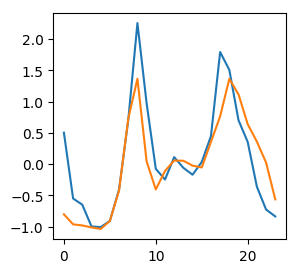

In [85]:
indice=423 #1185 is the changing hour day end of march
fig = plt.figure(dpi=100,figsize=(3,3))
#set(gca,'Color','k')
plt.plot(x[indice,:])
plt.plot(x_hat[indice,:])

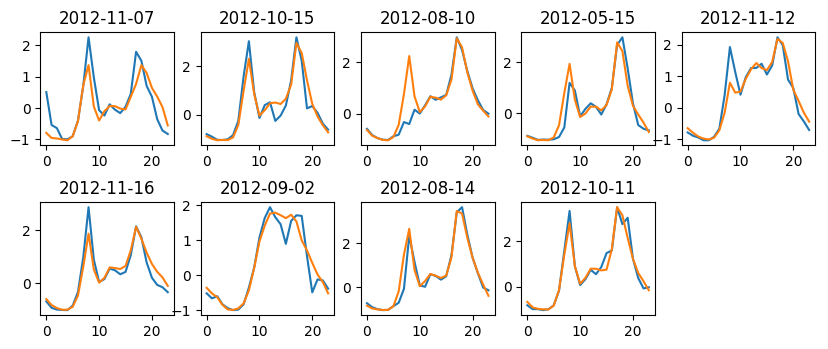

In [86]:
nPlots=10#len(idxMaxError)
nCols=5
nRows=int(nPlots/nCols)+1
fig = plt.figure(dpi=100,figsize=(10,nRows*2))
for i in range(1, nPlots):
    plt.subplot(nRows, nCols, i)
    fig.subplots_adjust(hspace=.5)
    indice=decreasingOrderIdx[i-1]
    plt.plot(x[indice,:])
    plt.plot(x_hat[indice,:])
    plt.title( calendar_Error_Highest.ds.dt.date.iloc[i-1])

## Study of holidays prediction

In [40]:
#preparation des features d'interet
yHd=calendar_info['is_holiday_day'].astype(int)
indicesHd=np.array([i for i in range(0, nPoints) if yHd[i] == 0])
yHd_only=yHd[yHd==1]
x_encoded_Hd=x_encoded[indicesHd,]

In [54]:
yWeekday=np.asarray(calendar_info['is_weekday'])[indicesHd]
results_wd=scoreKnnResults(x_encoded_Hd,yWeekday,type='classifier',k=5,cv=10)

In [56]:
results_wd['F1']

0.981032233097807

(442, 4)